In [1]:
import sys

import keras
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from numpy import array
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # to make any matplotlib plot automatically a 20x10


import configparser
config = configparser.ConfigParser()
config.read('config/mylstmconfig.ini')

scaler = MinMaxScaler(feature_range=(0,1))
eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=2)]
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


Using TensorFlow backend.


In [2]:
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

In [3]:
def create_mulitvariable_df(data):
    data.rename(columns={'aiTIT4045':'OAT'}, inplace=True)

    data["cdd"] = data.OAT - 65.0
    data.loc[data.cdd < 0, "cdd"] = 0
    data["hdd"] = 65.0 - data.OAT
    data.loc[data.hdd < 0, 'hdd'] = 0
    data["cdd2"] = data.cdd**2
    data["hdd2"] = data.hdd**2

    data2 = data.copy()
    del data
    month = [str('MONTH_'+ str(x+1)) for x in range(12)]
    data2["MONTH"]= data2.index.month
    data2["MONTH"] = data2["MONTH"].astype('category')
    month_df = pd.get_dummies(data=data2, columns=['MONTH'])
    
    month_df = month_df.T.reindex(month).T.fillna(0)
    month_df = month_df.drop(month_df.columns[0], axis = 1)
    
    tod = [str('TOD_' + str(x)) for x in range(24)]
    data2["TOD"] = data2.index.hour
    data2["TOD"] = data2["TOD"].astype('category')
    tod_df = pd.get_dummies(data = data2, columns = ['TOD'])
    tod_df = tod_df.T.reindex(tod).T.fillna(0)
    tod_df = tod_df.drop(tod_df.columns[0], axis = 1)
    
    dow = [str('DOW_' + str(x)) for x in range(7)]
    data2["DOW"] = data2.index.weekday
    data2["DOW"] = data2["DOW"].astype('category')
    dow_df = pd.get_dummies(data = data2, columns = ['DOW'])
    dow_df = dow_df.T.reindex(dow).T.fillna(0)
    dow_df = dow_df.drop(dow_df.columns[0], axis = 1)
    
    ### Create Weekend flag
    data2["WEEKEND"] = 0
    data2.loc[(dow_df.DOW_5 == 1) | (dow_df.DOW_6 == 1), 'WEEKEND'] = 1
    
    data2["shift1"] = data2.iloc[:,0].shift(2)

    data2["rolling24_mean"] = data2.iloc[:,0].rolling('24h').mean()
    data2["rolling24_max"] = data2.iloc[:,0].rolling('24h').max()
    data2["rolling24_min"] = data2.iloc[:,0].rolling('24h').min()
    
    data2 = pd.concat([data2, month_df, tod_df, dow_df], axis =1)

    data2.dropna(inplace=True)
    
    return data2

In [4]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
#df = pc.get_stream_by_point(point_list, end='*', calculation = calculation, interval= interval)
df = df.dropna(how='any')
df.head()

Grabbing WebIDs ...
WebID collection complete!
10:42:07: Sending API request... Chunk 1 of 1
10:42:10: Response recieved for 2 tags! (2.59)


/Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1027: FutureWarning: The errors argument is deprecated and will be removed in a future release. Use nonexistent='NaT' or nonexistent='raise' instead.
  "instead.", FutureWarning)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2016-01-01 00:00:00,2550.633333,40.409643
2016-01-01 01:00:00,2535.975618,40.079128
2016-01-01 02:00:00,2538.258333,40.090998
2016-01-01 03:00:00,2548.635795,40.114107
2016-01-01 04:00:00,2556.464644,39.902123


In [5]:
def clean_train_data(df):
    #mask1 = (df[point_name] > 2400 )& (df.index.year < 2019)
    mask1 = (df[point_name] > 2400 )
    df1 = df.loc[mask1]
    mask2 = (df.index.year>=2019)
    df2 = df.loc[mask2]
    return df1, df2
    #return pd.concat([df1,df2])   

In [6]:
df, df1 = clean_train_data(df)
print(f"df: {df.shape} \n df1: {df1.shape}")

df: (30850, 2) 
 df1: (4747, 2)


In [7]:
df = create_mulitvariable_df(df)
df1 = create_mulitvariable_df(df1)
df.head()

,GBSF_Electricity_Demand_kBtu,OAT,cdd,hdd,cdd2,hdd2,MONTH,TOD,DOW,WEEKEND,...,TOD_20,TOD_21,TOD_22,TOD_23,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 02:00:00,2538.258333,40.090998,0.0,24.909002,0.0,620.458395,1,2,4,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 03:00:00,2548.635795,40.114107,0.0,24.885893,0.0,619.307679,1,3,4,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 04:00:00,2556.464644,39.902123,0.0,25.097877,0.0,629.903431,1,4,4,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 05:00:00,2541.260449,39.394233,0.0,25.605767,0.0,655.655326,1,5,4,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 06:00:00,2569.566667,38.751869,0.0,26.248131,0.0,688.964360,1,6,4,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
np.setdiff1d(df.columns,df1.columns)


array([], dtype=object)

In [9]:
def scale_keras(X, y):
    # normalize the dataset
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler((0, 1))
    X = scaler_x.fit_transform(X)
    y = scaler_y.fit_transform(np.array(y).reshape((-1,1)))
    # split into train and test sets
    train_size = int(len(X) * 0.7)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[test_size:len(X)]
    y_train, y_test = y[0:train_size], y[test_size:len(y)]
    return X_train, X_test, y_train, y_test, scaler_x, scaler_y

In [10]:
y = df[point_name]
X = df.drop(columns=point_name)
y1 = df1[point_name]
X1 = df1.drop(columns=point_name)

In [11]:
X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_keras(X, y)
X1_train, X1_test, y1_train, y1_test, scaler_x1, scaler_y1 = scale_keras(X1, y1)

In [12]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X1_train = np.reshape(X1_train, (X1_train.shape[0], 1, X1_train.shape[1]))
X1_test = np.reshape(X1_test, (X1_test.shape[0], 1, X1_test.shape[1]))

In [62]:
train = DataFrame()
val = DataFrame()
np.random.seed(42)
epochs = 200
neurons = 100
for i in range(1):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error')
    #X,y = get_train()
    #valX, valY = get_val()
    # fit model
    history = model.fit(X_train, y_train, epochs = epochs, validation_split = 0.3, shuffle = False)
    # story history
    train[str(i)] = history.history['loss']
    val[str(i)] = history.history['val_loss']

Train on 15115 samples, validate on 6478 samples
Epoch 1/200
15115/15115 [==============================] - 4s 271us/step - loss: 0.0085 - val_loss: 0.0042
Epoch 2/200
15115/15115 [==============================] - 2s 141us/step - loss: 0.0022 - val_loss: 0.0040
Epoch 3/200
15115/15115 [==============================] - 2s 142us/step - loss: 0.0022 - val_loss: 0.0034
Epoch 4/200
15115/15115 [==============================] - 2s 136us/step - loss: 0.0022 - val_loss: 0.0041
Epoch 5/200
15115/15115 [==============================] - 2s 135us/step - loss: 0.0020 - val_loss: 0.0046
Epoch 6/200
15115/15115 [==============================] - 2s 138us/step - loss: 0.0019 - val_loss: 0.0043
Epoch 7/200
15115/15115 [==============================] - 2s 139us/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8/200
15115/15115 [==============================] - 2s 139us/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9/200
15115/15115 [==============================] - 2s 135us/step - loss: 0.0018 - val_l

15115/15115 [==============================] - 2s 135us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 77/200
15115/15115 [==============================] - 2s 139us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 78/200
15115/15115 [==============================] - 2s 136us/step - loss: 0.0010 - val_loss: 0.0017
Epoch 79/200
15115/15115 [==============================] - 2s 135us/step - loss: 9.9349e-04 - val_loss: 0.0018
Epoch 80/200
15115/15115 [==============================] - 2s 136us/step - loss: 9.8492e-04 - val_loss: 0.0018
Epoch 81/200
15115/15115 [==============================] - 2s 137us/step - loss: 9.7715e-04 - val_loss: 0.0018
Epoch 82/200
15115/15115 [==============================] - 2s 136us/step - loss: 9.6947e-04 - val_loss: 0.0018
Epoch 83/200
15115/15115 [==============================] - 2s 137us/step - loss: 9.6157e-04 - val_loss: 0.0018
Epoch 84/200
15115/15115 [==============================] - 2s 136us/step - loss: 9.5374e-04 - val_loss: 0.0018
Epoch 85/200
1511

Epoch 149/200
15115/15115 [==============================] - 2s 142us/step - loss: 7.0069e-04 - val_loss: 0.0019
Epoch 150/200
15115/15115 [==============================] - 2s 144us/step - loss: 6.9913e-04 - val_loss: 0.0019
Epoch 151/200
15115/15115 [==============================] - 2s 145us/step - loss: 6.9605e-04 - val_loss: 0.0019
Epoch 152/200
15115/15115 [==============================] - 2s 141us/step - loss: 6.9462e-04 - val_loss: 0.0019
Epoch 153/200
15115/15115 [==============================] - 2s 136us/step - loss: 6.9256e-04 - val_loss: 0.0019
Epoch 154/200
15115/15115 [==============================] - 2s 145us/step - loss: 6.8949e-04 - val_loss: 0.0019
Epoch 155/200
15115/15115 [==============================] - 2s 149us/step - loss: 6.8801e-04 - val_loss: 0.0018
Epoch 156/200
15115/15115 [==============================] - 2s 143us/step - loss: 6.8566e-04 - val_loss: 0.0019
Epoch 157/200
15115/15115 [==============================] - 2s 137us/step - loss: 6.8315e-04 - 

[  4   9  12  35  41  46 109 111 113 115]


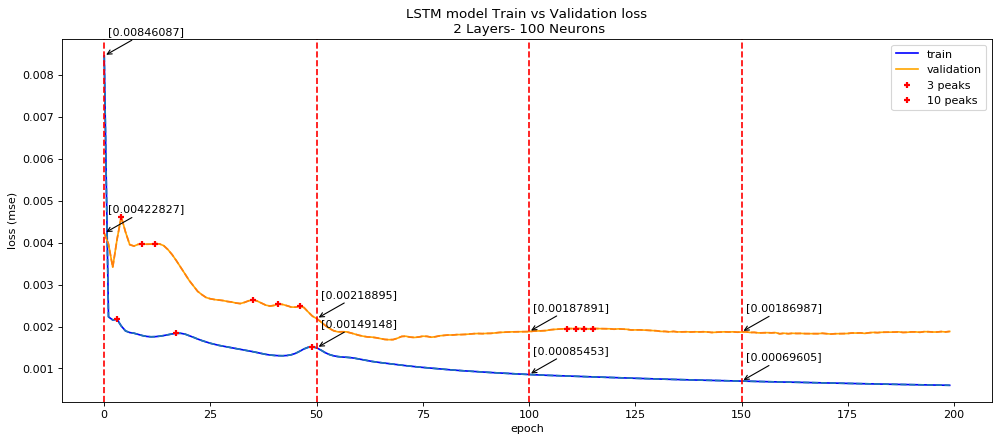

In [97]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
show_every = 50

vertical_lines = [x for x in range(epochs) if x % show_every == 0]

plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.title(f'LSTM model Train vs Validation loss\n 2 Layers- {neurons} Neurons')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
plt.legend()

unflat = train.values.tolist()
unflat1 = val.values.tolist()
flatten = [ item for sublist in  unflat for item in sublist]
flatten1 = [ item for sublist in  unflat1 for item in sublist]
import peakutils
from peakutils.plot import plot as pplot

indexes = peakutils.indexes(flatten, thres=0.005, min_dist=1)
indexes1 = peakutils.indexes(flatten1, thres=0.09, min_dist=1)

pplot(train.index, train.values, indexes)
pplot(val.index, val.values, indexes1)
for xc in vertical_lines:
    plt.axvline(x=xc, color = 'r', linestyle = '--')
for i,j in zip(train.index, train.values):
    if i % show_every == 0:
        plt.annotate(str(j), xy = (i,j ), xytext=(i+1, j+.00050),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
for i,j in zip(val.index, val.values):
    if i % show_every == 0:
        plt.annotate(str(j), xy = (i,j ), xytext=(i+1, j+.00050),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
#plt.savefig('new_300_epochs.png')
print(indexes1)
plt.show()

R2 of train = 0.959
R2 of test = 0.317

RMSE of train = 47.691
RMSE of test = 103.48

MAE of train = -23.625
MAE of test = -75.014


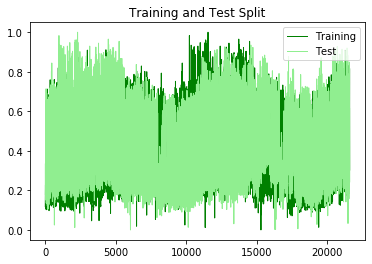

<Figure size 1296x144 with 0 Axes>

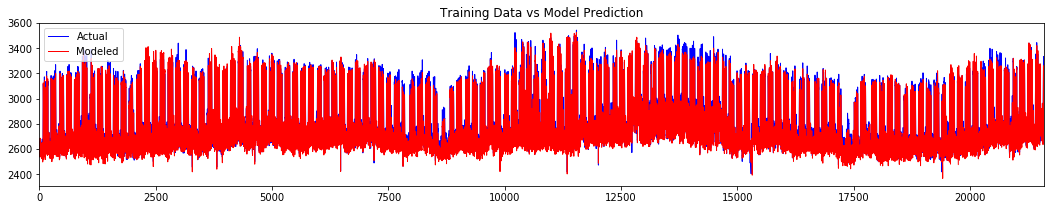

<Figure size 1296x144 with 0 Axes>

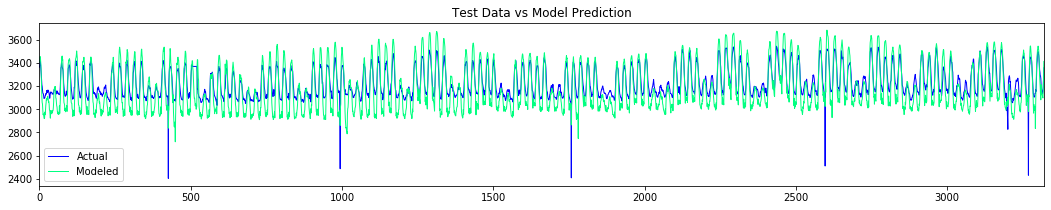

In [61]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
plt.plot(y_train, linewidth=1, color='green')
plt.plot(y_test, color='lightgreen', linewidth=1)
plt.title("Training and Test Split")
plt.legend(['Training','Test'])

pred_train = history.model.predict(X_train)
pred_train_inv = scaler_y.inverse_transform(pred_train.reshape(-1,1))
pred_test = history.model.predict(X1_test)
pred_test_inv = scaler_y.inverse_transform(pred_test.reshape(-1,1))
pred_test_inv = pred_test_inv+200
plt.figure(figsize=(18,2))
training_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y_train).reshape((-1,)),
                                   "Modeled":pred_train_inv.reshape((-1,))}, index=range(len(y_train)))
training_comparison.sort_index().plot(figsize=(18,3),
                         title="Training Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])
 
plt.figure(figsize=(18,2))
test_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y1_test).reshape((-1,)),
                                   "Modeled":pred_test_inv.reshape((-1,))}, index=range(len(y1_test)))
test_comparison.sort_index().plot(figsize=(18,3),
                     title="Test Data vs Model Prediction",
                     linewidth=1,
                     colormap='winter')

r2_train = r2_score(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1))
print(f"R2 of train = {round(r2_train,3)}")
r2_test = r2_score(scaler_y.inverse_transform(y1_test).reshape((-1,)), pred_test_inv.reshape(-1,1))
print(f"R2 of test = {round(r2_test,3)}")
print()
rmse_train = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1)))
print(f"RMSE of train = {round(rmse_train,3)}")
rmse_test = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y1_test).reshape((-1,)), pred_test_inv.reshape(-1,1)))
print(f"RMSE of test = {round(rmse_test,3)}")
print()
mae_train = np.median((pred_train_inv.reshape(-1,1) - scaler_y.inverse_transform(y_train).reshape((-1,))))
print(f"MAE of train = {round(mae_train,3)}")
mae_test = np.median((pred_test_inv.reshape(-1,1) - scaler_y.inverse_transform(y1_test).reshape((-1,))))
print(f"MAE of test = {round(mae_test,3)}")